In [2]:
import pandas as pd
import numpy as np
import datetime

dfs = []
# Data is split into 79 files
for i in range(10):
    df = pd.read_csv(f"data/2022_place_canvas_history-00000000000{i}.csv.gzip", compression="gzip")
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,timestamp,user_id,pixel_color,coordinate
0,2022-04-04 00:53:51.577 UTC,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,"826,1048"
1,2022-04-04 00:53:53.758 UTC,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,"583,1031"
2,2022-04-04 00:53:54.685 UTC,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,"1873,558"
3,2022-04-04 00:54:57.541 UTC,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,"1627,255"
4,2022-04-04 00:55:16.307 UTC,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,"49,1478"


Pandas have a built-in data parser but in my experience, it is super slow (in this example it was about 7 times slower).

In [3]:
def parse_date(date):
    try:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
        return datetime.datetime.strptime(date.strip(" UTC"), '%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(lambda x: parse_date(x))

Those cells are split to easily see the **runtime** of the **data parser**.

In [4]:
df['user_id'] = df['user_id'].astype('string')
df['pixel_color'] = df['pixel_color'].astype('string')

def parse_cord(cord):
    try:
        return float(cord.replace(",", "."))
    except:
        # Mods sometimes used the rectangle tool to censor NSFW, in those cases cords look like this (x1,y1,x2,y2).
        # With the code below we can get a tuple with opposite rectangle corners, but I didn't need that data.
        ###
        # cords = cord.split('.')
        # return (float(cord[0]+'.'+cord[1]), float(cord[2]+'.'+cord[3]))
        ###
        return np.NaN


df["coordinate"] = df["coordinate"].apply(lambda x: parse_cord(x))

df.dropna(how="any")
df.dtypes

timestamp      datetime64[ns]
user_id                string
pixel_color            string
coordinate            float64
dtype: object

### Prepare matplotlib
Each analysis will be split into three parts:
1. Description
2. Data editing
3. Ploting

In [10]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
figsize = (20, 10)

#### Pixels per color
We are getting **number of pixels** placed depending on **color** of the **pixel**.

In [6]:
colors = df["pixel_color"].value_counts().rename_axis('pixel_color').to_frame('counts').reset_index()
colors.head()

,pixel_color,counts
0,#000000,4166797
1,#FFFFFF,3107295
2,#FF4500,1558313
3,#2450A4,1281347
4,#FFD635,939332


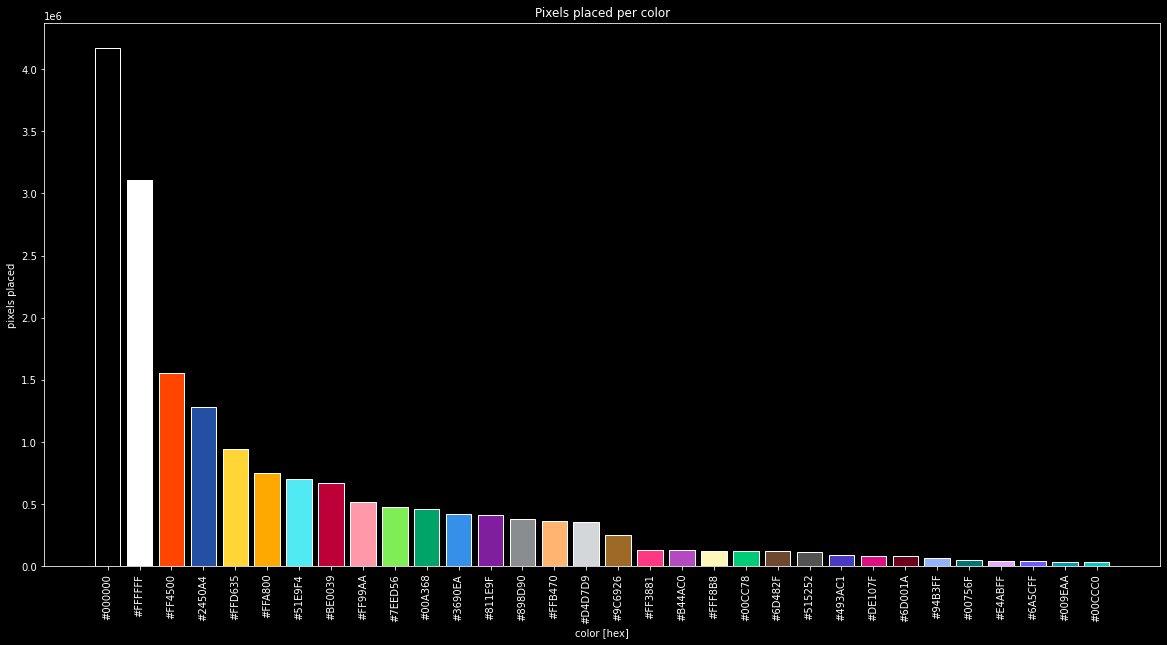

In [7]:
fig, ax = plt.subplots(figsize=figsize)
ax.bar(colors["pixel_color"], colors["counts"], color=colors["pixel_color"], edgecolor="#FFFFFF")
ax.set_title('Pixels placed per color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_counts.pdf')

#### Max pixels placed per user based on color
Same thing as above but we are getting **maximum** number of **pixels** placed by **one user** based on **color**.

In [8]:
colors = df.iloc[:, 1:3]
colors['count'] = 1
colors= pd.pivot_table(colors, values='count', index='user_id', columns='pixel_color', aggfunc='count')

color_user = pd.DataFrame(columns=["pixel_color", "user_max"])
for name, column in colors.items():
    color_user = color_user.append({"pixel_color": name, "user_max": column.max()}, ignore_index = True)
color_user.sort_values(by='user_max', ascending = False, inplace=True)


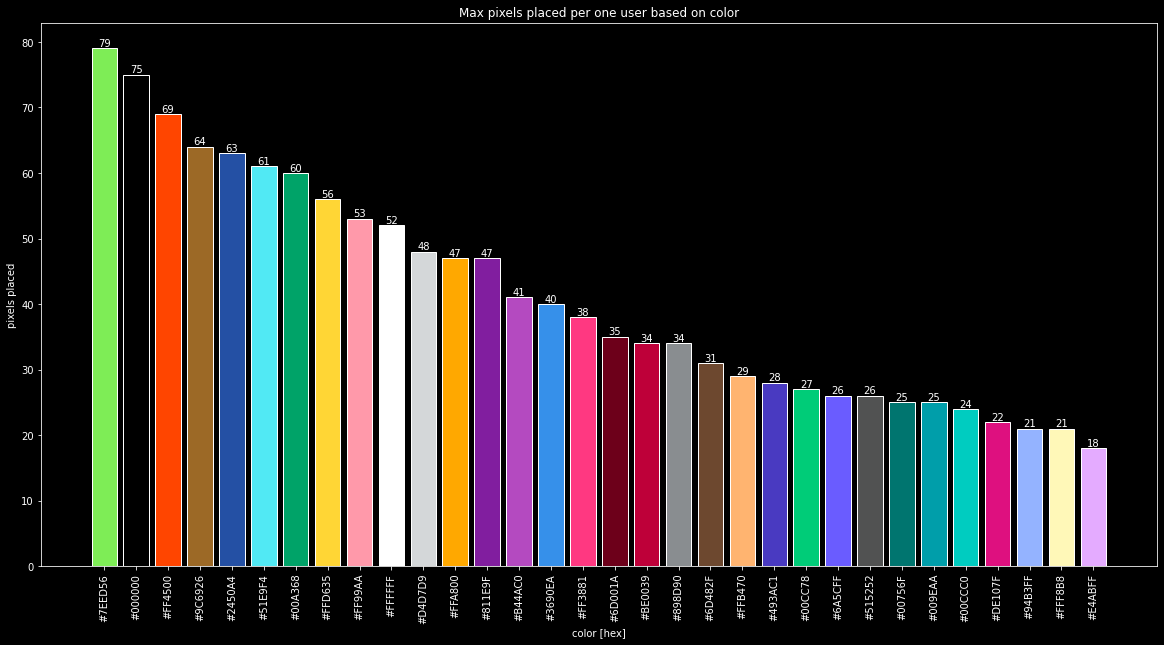

In [9]:
fig, ax = plt.subplots(figsize=figsize)
bars = ax.bar(color_user["pixel_color"], color_user["user_max"], color=color_user["pixel_color"], edgecolor="#FFFFFF")
ax.bar_label(bars)
ax.set_title('Max pixels placed per one user based on color')
ax.set_xlabel('color [hex]')
ax.set_ylabel('pixels placed')
plt.xticks(rotation=90)
fig.savefig('./plots/color_user_counts.pdf')

In [10]:
pix_usr = df["user_id"].value_counts().to_frame('pixels').reset_index()
# We really only need the counts now
pix_usr = pix_usr.drop(["index"], 1)
# We will use pix_usr later on
pix_usr_count = pix_usr["pixels"].value_counts().rename_axis('pixels').to_frame('howmany').reset_index()
pix_usr_count

C:\Users\Dawid\AppData\Local\Temp/ipykernel_4140/151073367.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pix_usr = pix_usr.drop(["index"], 1)


,pixels,howmany
0,1,1473850
1,2,698499
2,3,436714
3,4,307195
4,5,213890
...,...,...
105,108,1
106,110,1
107,107,1
108,102,1


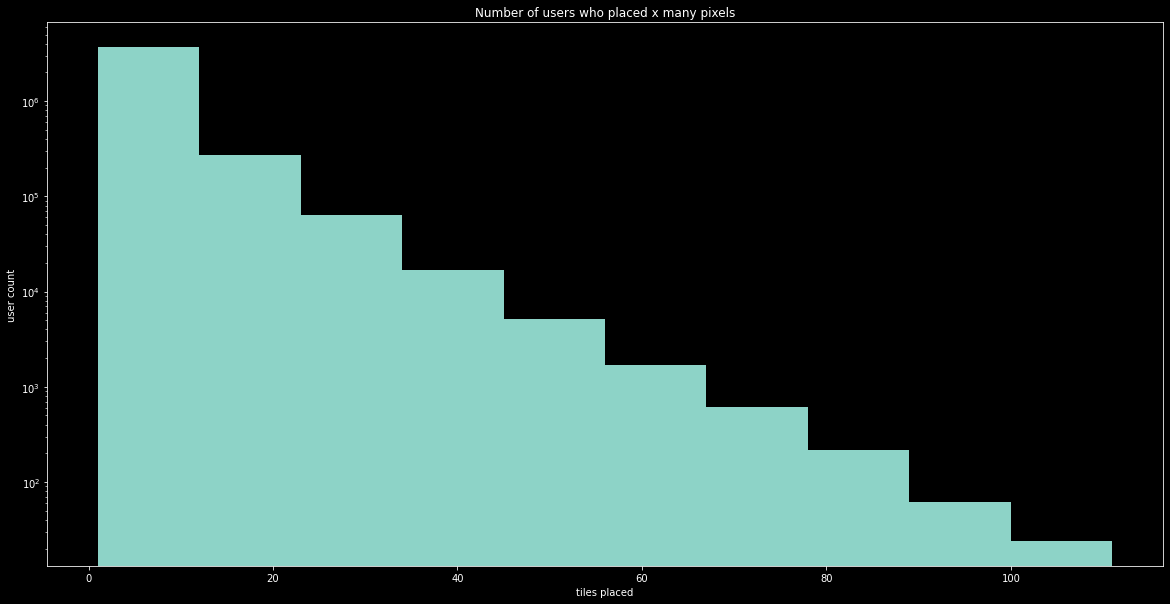

In [11]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_yscale('log')
ax.set_ylabel('user count')
ax.set_xlabel('tiles placed')
ax.set_title('Number of users who placed x many pixels')
ax.hist(pix_usr['pixels'])
fig.savefig("./plots/tiles_per_user.pdf")

In [12]:
pix_usr = pix_usr[:10]
pix_usr.index += 1
pix_usr

,pixels
1,111
2,110
3,109
4,108
5,107
6,106
7,106
8,106
9,105
10,105


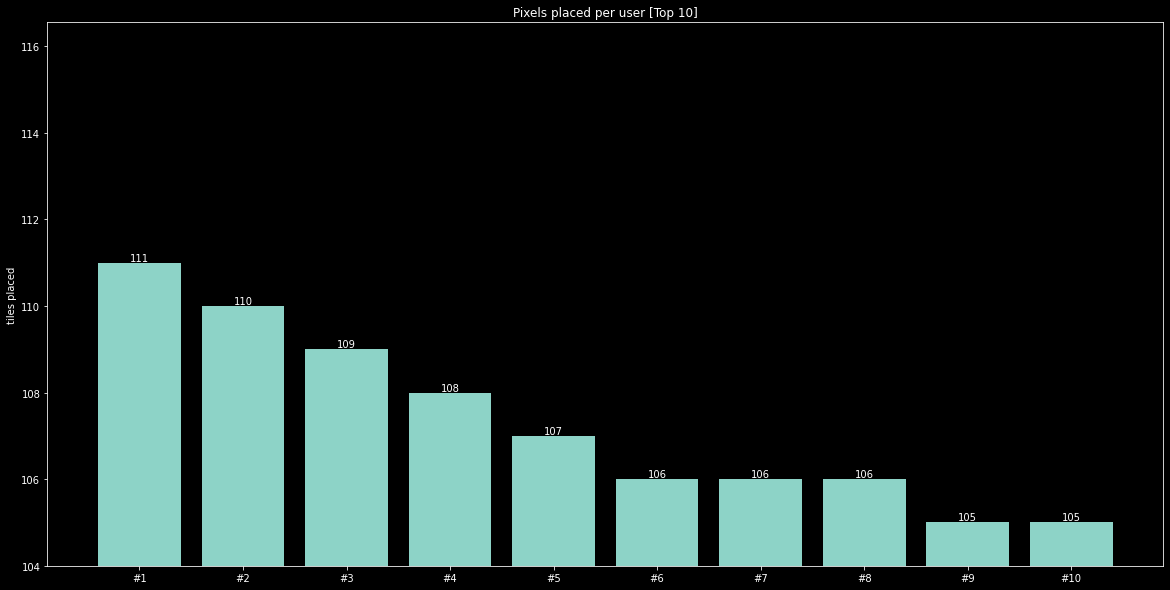

In [14]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel('tiles placed')
ax.set_title('Pixels placed per user [Top 10]')
bars = ax.bar(['#'+str(i) for i in pix_usr.index], pix_usr['pixels'])
ax.bar_label(bars)
ax.set_ylim(ymin=min(pix_usr['pixels']-1))
fig.savefig('./plots/top10_tiles_per_user.pdf')

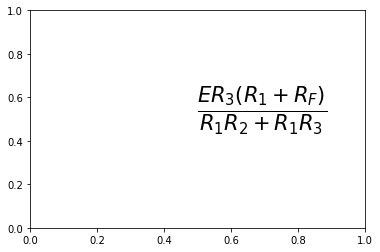

In [1]:
from sympy import symbols, Eq, solve, limit, oo, latex, print_latex
import matplotlib.pyplot as plt

def zadanie1():
    #R_o = 0.32e3
    #R_1 = 4.6e3
    #R_2 = 127.4
    #R_3 = 13
    #R_F = 45.08e3
    #E = 4
    R_1, R_F, E, R_3, R_2= symbols('R_1 R_F E R_3 R_2')
    u_o, k = symbols('u_o k')
    u_m = E * R_3/(R_2 + R_3)
    eq1 = Eq(u_o, k*(u_m - u_o*R_1/(R_1+R_F)))
    u_output = limit(solve(eq1, u_o)[0], k, oo)
    l = latex(u_output)
    fig, ax = plt.subplots()
    ax.text(0.5, 0.5, f'${l}$', fontsize=30)
    #print(f"u_o: {u_output}V")
    #i_o = u_output / R_o
    #print(f"i_o: {i_o*1000} 

zadanie1()